# Setup

In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection as cv
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, recall_score, roc_curve, auc, accuracy_score, precision_score, f1_score, \
    classification_report
import time
from sklearn.model_selection import cross_val_score, LearningCurveDisplay, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from statsmodels.stats.proportion import proportion_confint

In [25]:
data = pd.read_csv('data_balanced_normalized.csv')
print(f"Total samples: {data.shape[0]}")

data.info()

# nuestra variable a predecir es "heart_attack"
X = data.drop('heart_attack',axis=1)
y = data['heart_attack']

# Split de 50/50 train/test, justificacion en el report
(X_train, X_test, y_train, y_test) = cv.train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Total samples: 127030
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127030 entries, 0 to 127029
Data columns (total 34 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   age                              127030 non-null  float64
 1   hypertension                     127030 non-null  float64
 2   diabetes                         127030 non-null  float64
 3   cholesterol_level                127030 non-null  float64
 4   obesity                          127030 non-null  float64
 5   waist_circumference              127030 non-null  float64
 6   family_history                   127030 non-null  float64
 7   sleep_hours                      127030 non-null  float64
 8   blood_pressure_systolic          127030 non-null  float64
 9   blood_pressure_diastolic         127030 non-null  float64
 10  fasting_blood_sugar              127030 non-null  float64
 11  cholesterol_hdl                  127030 non

# Hyperparameter Tuning with GridSearchCV - DecisionTreeClassifier

In [26]:
params = {
    "criterion": ['gini', 'entropy'],
    "min_impurity_decrease": list(np.linspace(0,0.5,21)),
    "min_samples_split":list(range(2,20,2)),
}
dt_grid_search  = GridSearchCV(
    DecisionTreeClassifier(criterion = "entropy", random_state=1),
    param_grid = params,
    cv = 5,
    n_jobs = -1,
    scoring='recall'
)
dt_grid_search.fit(X_train, y_train)
print(f"Best Params = {dt_grid_search .best_params_}  -  Recall = {dt_grid_search .best_score_}")

Best Params = {'criterion': 'entropy', 'min_impurity_decrease': np.float64(0.0), 'min_samples_split': 2}  -  Recall = 0.8118425196850394


# Train Decision Tree with Optimized Parameters

Accuracy: 0.8122
Recall: 0.8151
Precision: 0.8103
F1-score: 0.8127
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     31764
           1       0.81      0.82      0.81     31751

    accuracy                           0.81     63515
   macro avg       0.81      0.81      0.81     63515
weighted avg       0.81      0.81      0.81     63515


Confusion Matrix:
[[25707  6057]
 [ 5871 25880]]


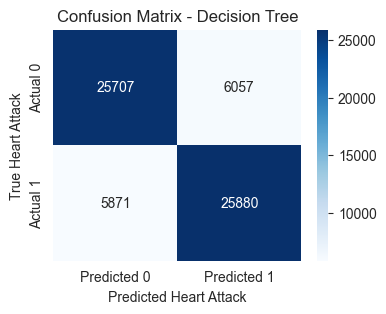

ROC AUC: 0.8122


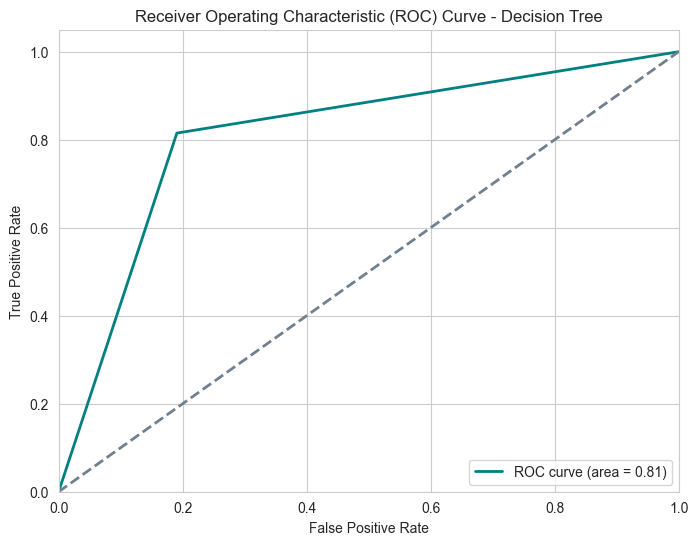

Interval of confidence (Recall): (0.812061523317642, 0.8181073946904189)


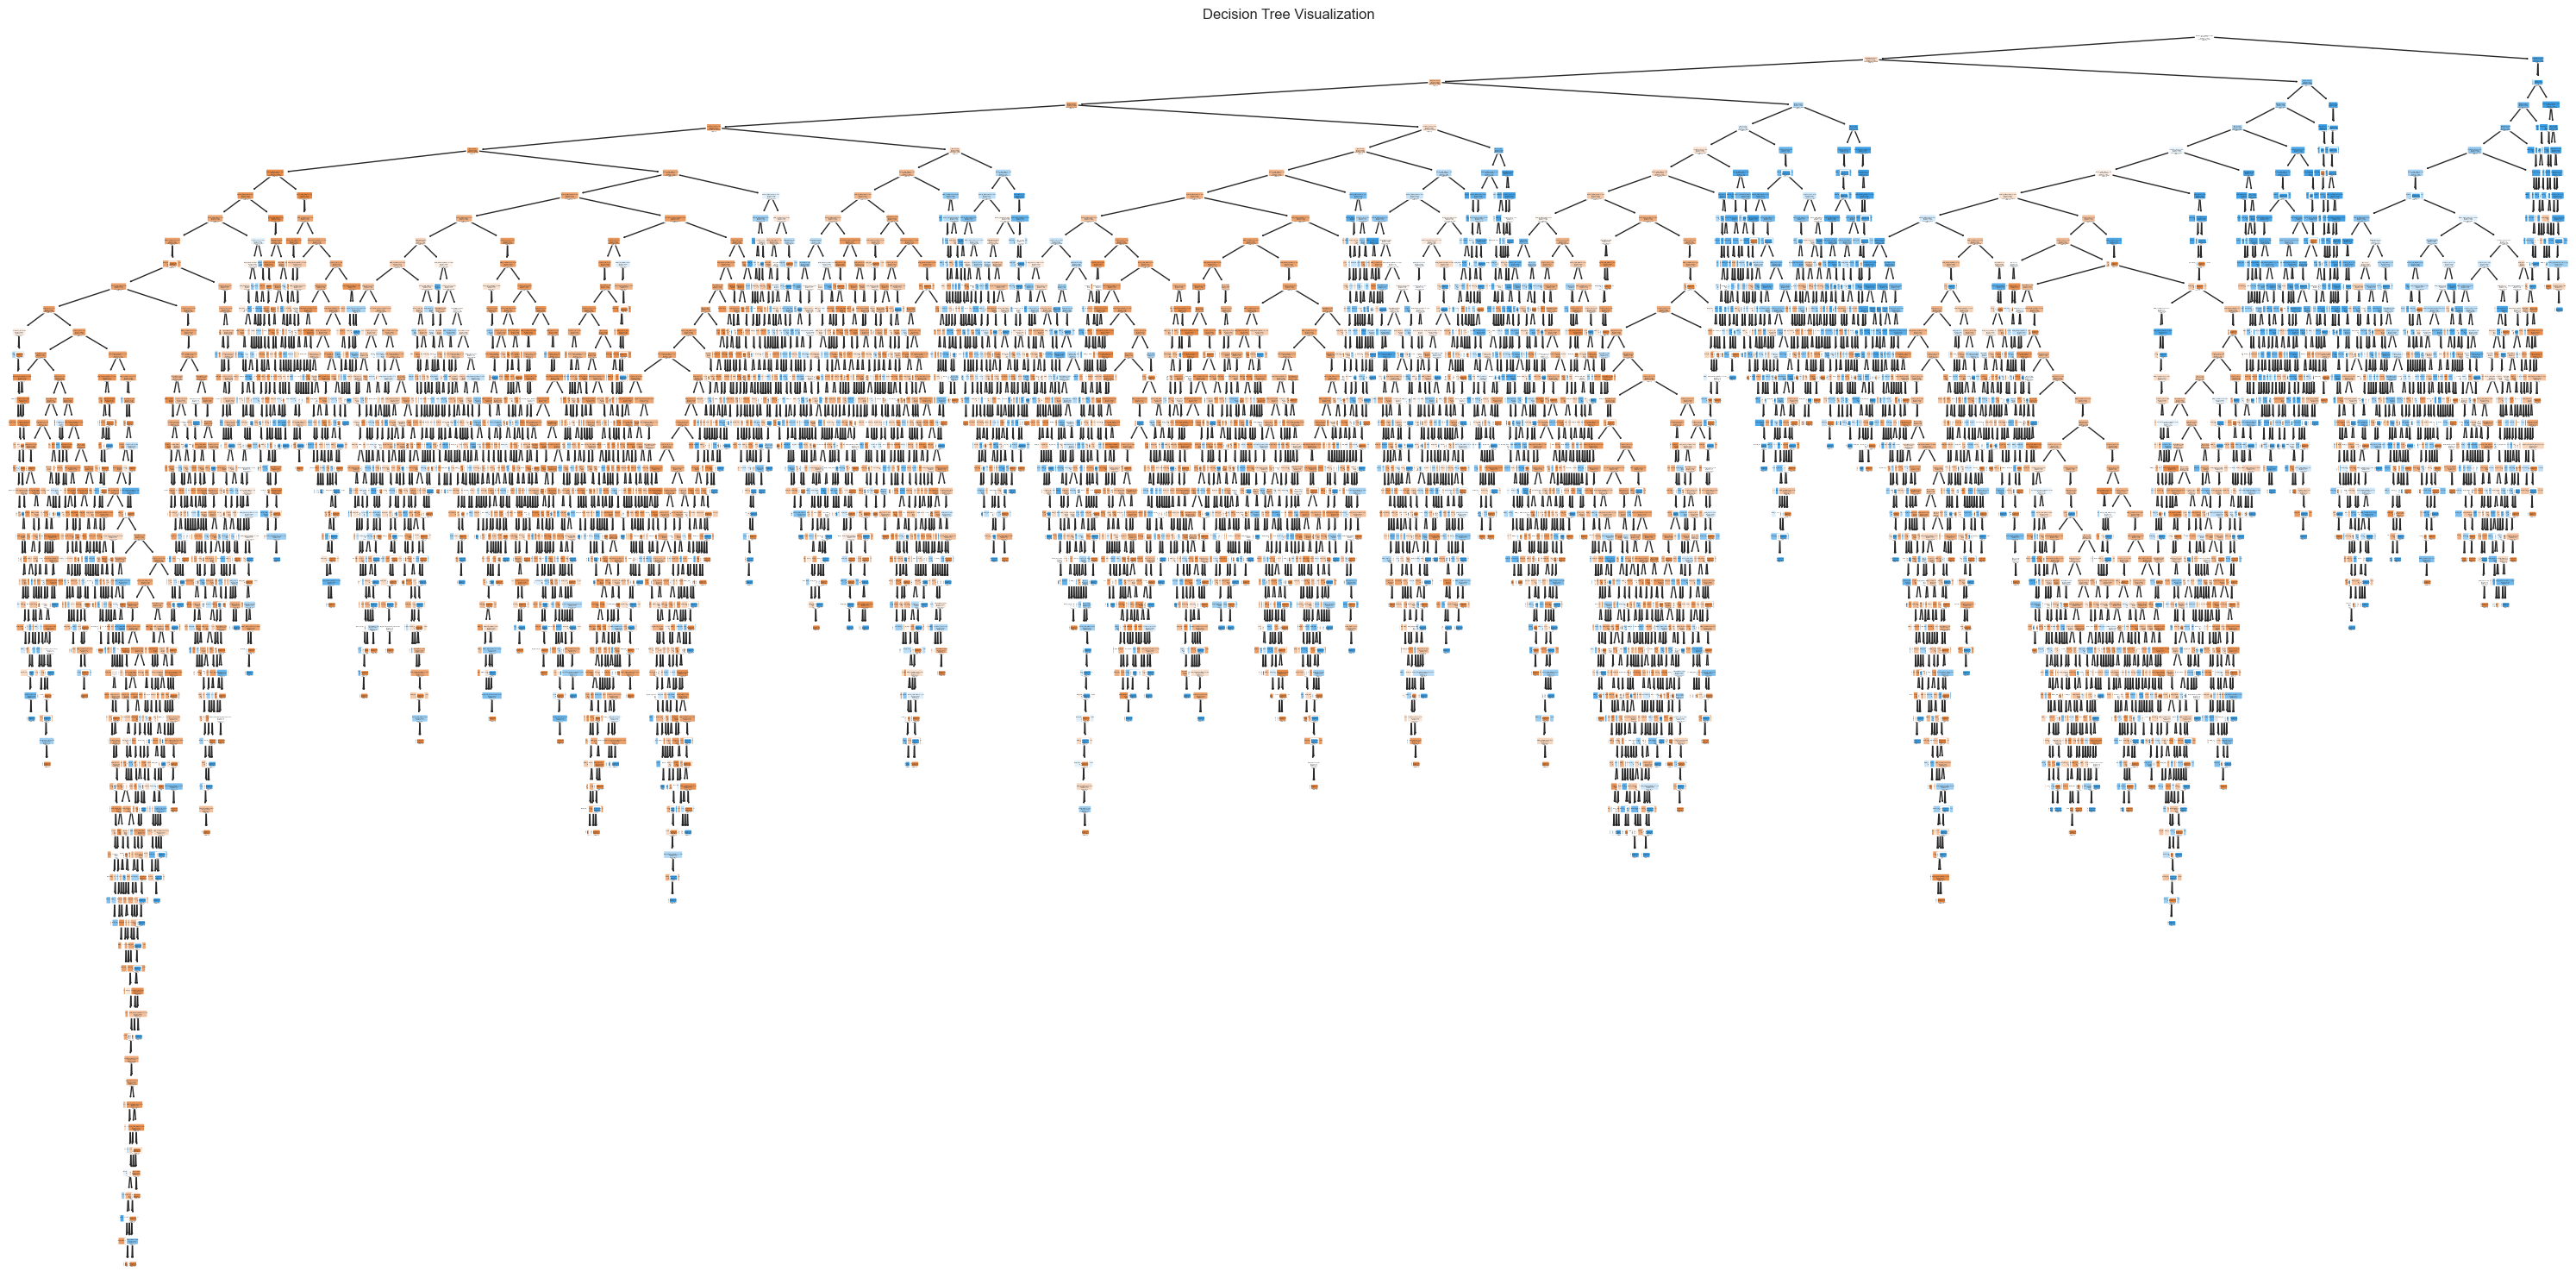

In [27]:
cdt= DecisionTreeClassifier(
    criterion = "entropy",
    min_samples_split = dt_grid_search.best_params_["min_samples_split"],
    min_impurity_decrease = dt_grid_search.best_params_["min_impurity_decrease"],
    random_state=1
)
clf = cdt.fit(X_train, y_train)

pred = clf.predict(X_test)
pred_proba = cdt.predict_proba(X_test)[:, 1]

# accuracy, recall, precision, f1
accuracy = accuracy_score(y_test, pred)
recall = recall_score(y_test, pred)
precision = precision_score(y_test, pred)
f1 = f1_score(y_test, pred)
class_report = classification_report(y_test, pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Classification Report")
print(class_report)

# confusion matrix
conf_matrix = confusion_matrix(y_test, pred)
print("\nConfusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Heart Attack')
plt.ylabel('True Heart Attack')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='teal', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='slategray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# intervalo de confianza
estimated_tp_count = int(round(recall * len(y_test)))
print("Interval of confidence (Recall):", proportion_confint(count=estimated_tp_count, nobs=X_test.shape[0], alpha=0.05, method='binom_test'))

# figura arbol
plt.figure(figsize=(30, 15))
plot_tree(cdt, filled=True, rounded=True, feature_names=X.columns, class_names=['0', '1'])
plt.title('Decision Tree Visualization')
plt.tight_layout()
plt.show()

# guardar datos obtenidos para la comparacion final
dt_metrics = {
    'Accuracy': accuracy,
    'Recall': recall,
    'Precision': precision,
    'F1-score': f1,
    'ROC AUC': roc_auc,
    'Confusion Matrix': conf_matrix,
    'FPR': fpr,
    'TPR': tpr,
    'y_proba': pred_proba
}

## Learning Curve

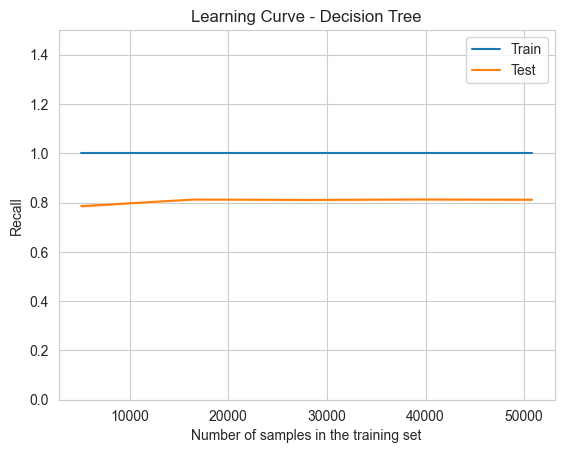

In [28]:
train_sizes, train_scores, test_scores = learning_curve(
    cdt, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='recall'
)
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Recall")
display.plot()
plt.title('Learning Curve - Decision Tree')
plt.ylim(0.0, 1.5)
plt.show()

# Decorator for timing model execution


In [29]:
def compute_executions_time(function):
    def wrapper():
        start_time = time.time()  # init measuring time
        function()  # execute function
        print(f"\n{time.time() - start_time} seconds")  # print execution time
    return wrapper

# Random Forest Classifier


## Hyperparameter Tuning with cross validation - Random Forest


Recall: 0.7748 ± 0.0105 [nº estimators (trees): 1]
Time: 0.6237294673919678 [nº estimators (trees): 1]
Recall: 0.6503 ± 0.0130 [nº estimators (trees): 2]
Time: 0.78495192527771 [nº estimators (trees): 2]
Recall: 0.8105 ± 0.0049 [nº estimators (trees): 5]
Time: 1.2131702899932861 [nº estimators (trees): 5]
Recall: 0.7894 ± 0.0036 [nº estimators (trees): 10]
Time: 2.2376039028167725 [nº estimators (trees): 10]
Recall: 0.8016 ± 0.0036 [nº estimators (trees): 20]
Time: 3.551814317703247 [nº estimators (trees): 20]
Recall: 0.8078 ± 0.0021 [nº estimators (trees): 50]
Time: 7.894554615020752 [nº estimators (trees): 50]
Recall: 0.8109 ± 0.0030 [nº estimators (trees): 100]
Time: 17.06643533706665 [nº estimators (trees): 100]
Recall: 0.8130 ± 0.0026 [nº estimators (trees): 200]
Time: 31.477078676223755 [nº estimators (trees): 200]


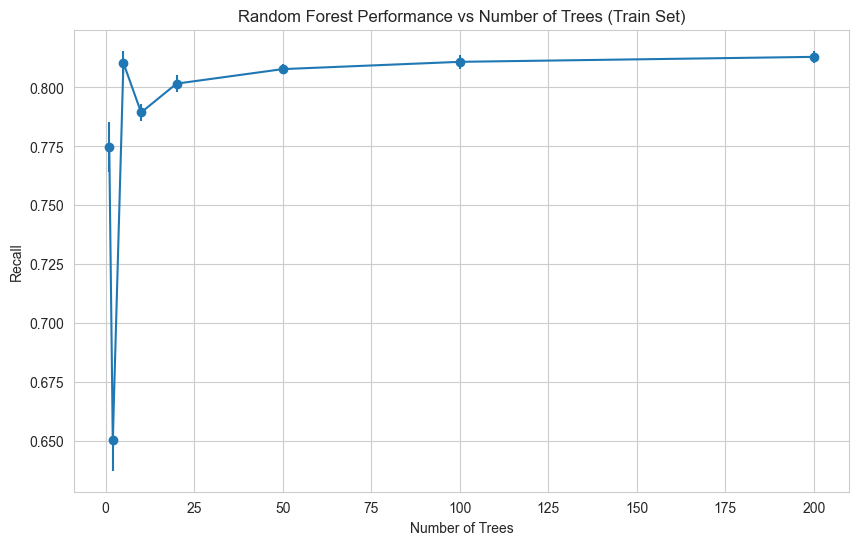


65.0662727355957 seconds


In [30]:
@compute_executions_time
def execute_random_forest_with_different_estimators_and_cv():
    results = []
    options = [1, 2, 5, 10, 20, 50, 100, 200]
    for n_estimators in options:
        start_time_iter = time.time()
        random_forest_clf = RandomForestClassifier(
            n_estimators=n_estimators,
            random_state=1,
            n_jobs=-1
        )
        scores = cross_val_score(
            estimator=random_forest_clf,
            X=X_train,
            y=y_train,
            cv=5,
            scoring="recall",
            n_jobs=-1
        )
        end_time_iter = time.time()
        execution_time_iter = end_time_iter - start_time_iter

        results.append((n_estimators, scores.mean(), scores.std()))
        print(f"Recall: {scores.mean():.4f} ± {scores.std():.4f} [nº estimators (trees): {n_estimators}]")
        print(f"Time: {execution_time_iter} [nº estimators (trees): {n_estimators}]")

    plt.figure(figsize=(10, 6))
    means = [r[1] for r in results]
    stds = [r[2] for r in results]
    plt.errorbar(options, means, yerr=stds, fmt='-o')
    plt.xlabel('Number of Trees')
    plt.ylabel('Recall')
    plt.title('Random Forest Performance vs Number of Trees (Train Set)')
    plt.grid(True)
    plt.show()

    return results

rf_results = execute_random_forest_with_different_estimators_and_cv()

## Hyperparameter Tuning with GridSearchCV - Random Forest


Time RandomForest GridSearchCV: 559.77 seconds
Best Params = {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 80}  -  Recall = 0.8108661417322836
RandomForest Accuracy: 0.8626
RandomForest Recall: 0.8125
RandomForest Precision: 0.9028
RandomForest F1-score: 0.8553
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     31764
           1       0.90      0.81      0.86     31751

    accuracy                           0.86     63515
   macro avg       0.87      0.86      0.86     63515
weighted avg       0.87      0.86      0.86     63515

[[28986  2778]
 [ 5952 25799]]


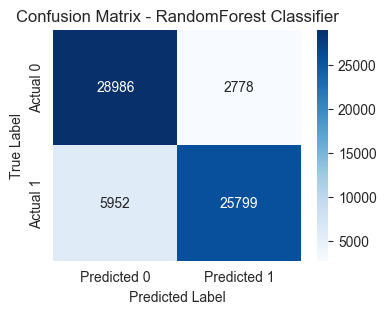

RandomForest ROC AUC: 0.9363


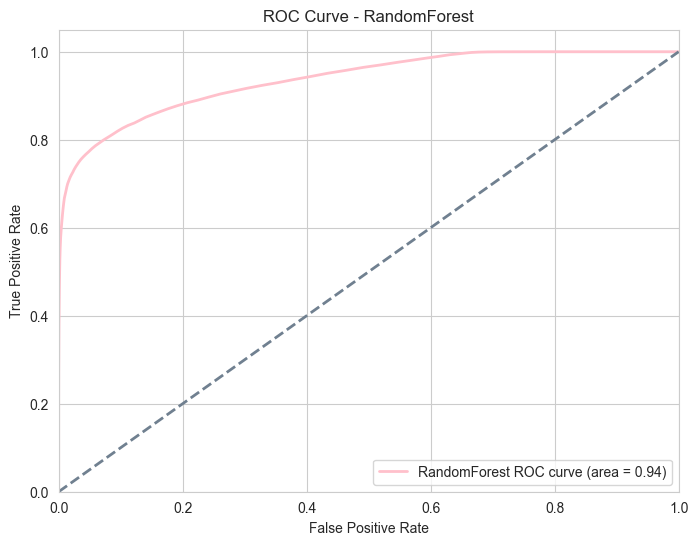

Interval of confidence (Recall random forest): (0.8094951886665664, 0.8155725470882684)


In [31]:
params = {
    "n_estimators": [30, 50, 80],
    "max_features": ['sqrt', 'log2', 0.5, 0.7],
    "max_depth": [None, 10, 20]
}
grid_search_rf  = GridSearchCV(
    RandomForestClassifier(random_state=1),
    param_grid = params,
    cv = 5,
    n_jobs = -1,
    scoring='recall'
)

start_time_rf_grid = time.time()
grid_search_rf.fit(X_train, y_train)
end_time_rf_grid = time.time()

print(f"Time RandomForest GridSearchCV: {end_time_rf_grid - start_time_rf_grid:.2f} seconds")
print(f"Best Params = {grid_search_rf.best_params_}  -  Recall = {grid_search_rf.best_score_}")

best_rf_classifier = grid_search_rf.best_estimator_
y_pred_rf = best_rf_classifier.predict(X_test)
y_proba_rf = best_rf_classifier.predict_proba(X_test)[:, 1]

# accuracy, recall, precision, f1
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)
print(f"RandomForest Accuracy: {accuracy_rf:.4f}")
print(f"RandomForest Recall: {recall_rf:.4f}")
print(f"RandomForest Precision: {precision_rf:.4f}")
print(f"RandomForest F1-score: {f1_rf:.4f}")
print(f"RandomForest Classification Report:")
print(class_report_rf)

#confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix_rf)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - RandomForest Classifier')
plt.show()

# ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print(f"RandomForest ROC AUC: {roc_auc_rf:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='pink', lw=2, label=f'RandomForest ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='slategray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# intervalo de confianza
estimated_tp_count = int(round(recall_rf * len(y_test)))
print("Interval of confidence (Recall random forest):", proportion_confint(count=estimated_tp_count, nobs=X_test.shape[0], alpha=0.05, method='binom_test'))

# Guardar datos para comparacion final
rf_metrics = {
    'Accuracy': accuracy_rf,
    'Recall': recall_rf,
    'Precision': precision_rf,
    'F1-score': f1_rf,
    'ROC AUC': roc_auc_rf,
    'Confusion Matrix': conf_matrix_rf,
    'FPR': fpr_rf,
    'TPR': tpr_rf,
    'y_proba': y_proba_rf
}


## Learning Curve - Random Forest

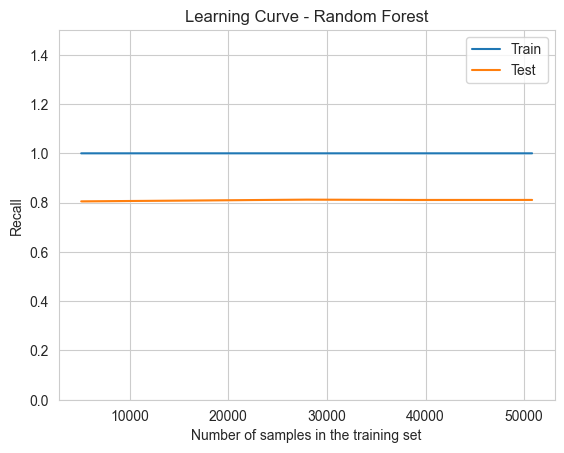

In [32]:
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(
    best_rf_classifier, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='recall'
)

display = LearningCurveDisplay(train_sizes=train_sizes_rf, train_scores=train_scores_rf, test_scores=test_scores_rf, score_name="Recall")
display.plot()
plt.title('Learning Curve - Random Forest')
plt.ylim(0.0, 1.5)
plt.show()

# Ada Boost Classifier

## Hyperparameter Tuning with cross validation - Ada Boost

Recall: 0.4233 ± 0.0479 [nº estimators (trees): 1]
Time: 0.4052700996398926 [nº estimators (trees): 1]
Recall: 0.4233 ± 0.0479 [nº estimators (trees): 2]
Time: 0.5056052207946777 [nº estimators (trees): 2]
Recall: 0.7150 ± 0.1391 [nº estimators (trees): 5]
Time: 0.9167921543121338 [nº estimators (trees): 5]
Recall: 0.7649 ± 0.0169 [nº estimators (trees): 10]
Time: 1.5992622375488281 [nº estimators (trees): 10]
Recall: 0.7975 ± 0.0315 [nº estimators (trees): 20]
Time: 3.399331569671631 [nº estimators (trees): 20]
Recall: 0.8209 ± 0.0139 [nº estimators (trees): 50]
Time: 8.090933322906494 [nº estimators (trees): 50]
Recall: 0.8522 ± 0.0029 [nº estimators (trees): 100]
Time: 16.63301110267639 [nº estimators (trees): 100]
Recall: 0.8525 ± 0.0028 [nº estimators (trees): 200]
Time: 30.060189962387085 [nº estimators (trees): 200]


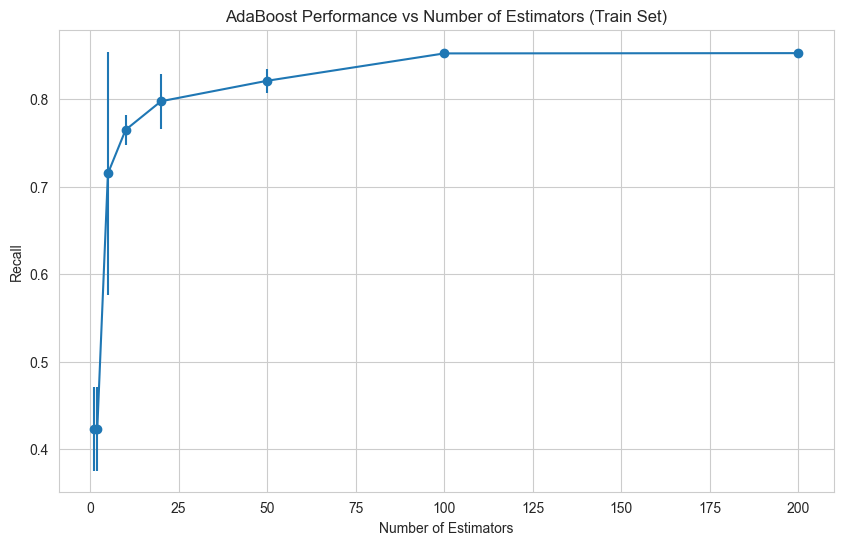


61.845704555511475 seconds


In [33]:
@compute_executions_time
def execute_ada_boost_classifier_for_different_classifiers():
    results = []
    options = [1, 2, 5, 10, 20, 50, 100, 200]
    for n_estimators in options:
        start_time_iter = time.time()
        ada_boost_classifier = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1, random_state=1),
            n_estimators=n_estimators,
            random_state=1
        )
        scores = cross_val_score(
            ada_boost_classifier,
            X_train,
            y_train,
            cv = 5,
            scoring = "recall",
            n_jobs=-1
        )
        end_time_iter = time.time()

        execution_time_iter = end_time_iter - start_time_iter

        results.append((n_estimators, scores.mean(), scores.std()))
        print(f"Recall: {scores.mean():.4f} ± {scores.std():.4f} [nº estimators (trees): {n_estimators}]")
        print(f"Time: {execution_time_iter} [nº estimators (trees): {n_estimators}]")

    plt.figure(figsize=(10, 6))
    means = [r[1] for r in results]
    stds = [r[2] for r in results]
    plt.errorbar(options, means, yerr=stds, fmt='-o')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Recall')
    plt.title('AdaBoost Performance vs Number of Estimators (Train Set)')
    plt.grid(True)
    plt.show()
    return results

ada_results = execute_ada_boost_classifier_for_different_classifiers()

## Hyperparameter Tuning with GridSearchCV - Ada Boost

Time AdaBoost GridSearchCV: 274.98 seconds
Best Params = {'learning_rate': 1.0, 'n_estimators': 110}  -  Recall = 0.8523779527559056
AdaBoost Accuracy: 0.8553
AdaBoost Recall: 0.8536
AdaBoost Precision: 0.8565
AdaBoost F1-score: 0.8551
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86     31764
           1       0.86      0.85      0.86     31751

    accuracy                           0.86     63515
   macro avg       0.86      0.86      0.86     63515
weighted avg       0.86      0.86      0.86     63515

[[27224  4540]
 [ 4648 27103]]


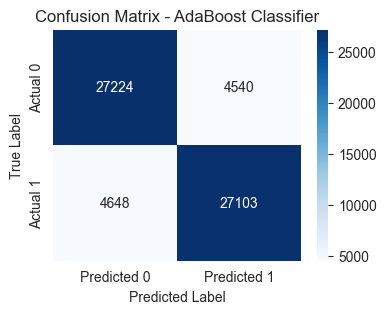

AdaBoost ROC AUC: 0.9380


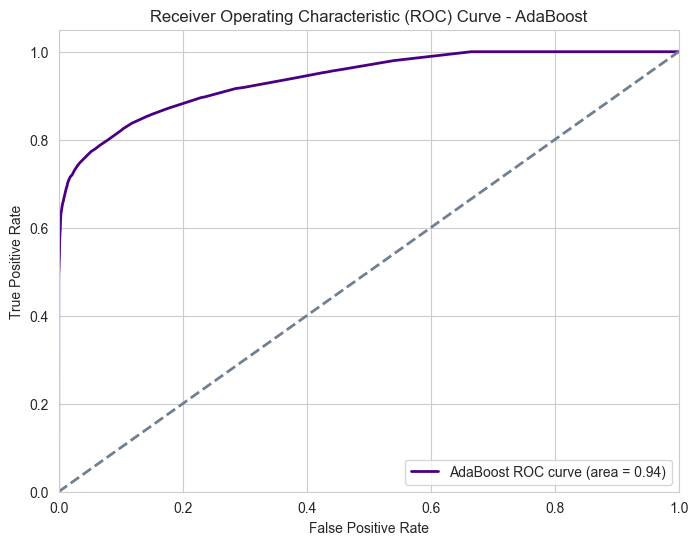

Interval of confidence (Recall adaboost): (0.8508399364401279, 0.8563426162307032)


In [34]:
param_grid_ab = {
    "n_estimators": [80, 90, 100, 110, 120],
    "learning_rate": [0.01, 0.1, 0.5, 1.0]
}

grid_search_ab = GridSearchCV(
    AdaBoostClassifier(random_state=1),
    param_grid_ab,
    cv=5,
    scoring="recall",
    n_jobs=-1,
)

start_time_ab_grid = time.time()
grid_search_ab.fit(X_train, y_train)
end_time_ab_grid = time.time()

best_ab_classifier = grid_search_ab.best_estimator_
print(f"Time AdaBoost GridSearchCV: {end_time_ab_grid - start_time_ab_grid:.2f} seconds")
print(f"Best Params = {grid_search_ab.best_params_}  -  Recall = {grid_search_ab.best_score_}")

y_pred_ab = best_ab_classifier.predict(X_test)
y_proba_ab = best_ab_classifier.predict_proba(X_test)[:, 1]

# accuracy, recall, precision, f1
accuracy_ab = accuracy_score(y_test, y_pred_ab)
recall_ab = recall_score(y_test, y_pred_ab)
precision_ab = precision_score(y_test, y_pred_ab)
f1_ab = f1_score(y_test, y_pred_ab)
class_report_ab = classification_report(y_test, y_pred_ab)
print(f"AdaBoost Accuracy: {accuracy_ab:.4f}")
print(f"AdaBoost Recall: {recall_ab:.4f}")
print(f"AdaBoost Precision: {precision_ab:.4f}")
print(f"AdaBoost F1-score: {f1_ab:.4f}")
print(f"AdaBoost Classification Report:")
print(class_report_ab)

# confusion matrix
conf_matrix_ab = confusion_matrix(y_test, y_pred_ab)
print(conf_matrix_ab)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_ab, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - AdaBoost Classifier')
plt.show()

# ROC curve
fpr_ab, tpr_ab, _ = roc_curve(y_test, y_proba_ab)
roc_auc_ab = auc(fpr_ab, tpr_ab)
print(f"AdaBoost ROC AUC: {roc_auc_ab:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr_ab, tpr_ab, color='indigo', lw=2, label=f'AdaBoost ROC curve (area = {roc_auc_ab:.2f})')
plt.plot([0, 1], [0, 1], color='slategray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - AdaBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# intervalo de confianza
estimated_tp_count = int(round(recall_ab * len(y_test)))
print("Interval of confidence (Recall adaboost):", proportion_confint(count=estimated_tp_count, nobs=X_test.shape[0], alpha=0.05, method='binom_test'))

adaboost_metrics = {
    'Accuracy': accuracy_ab,
    'Recall': recall_ab,
    'Precision': precision_ab,
    'F1-score': f1_ab,
    'ROC AUC': roc_auc_ab,
    'Confusion Matrix': conf_matrix_ab,
    'FPR': fpr_ab,
    'TPR': tpr_ab,
    'y_proba': y_proba_ab
}


# Learning Curve - Ada Boost

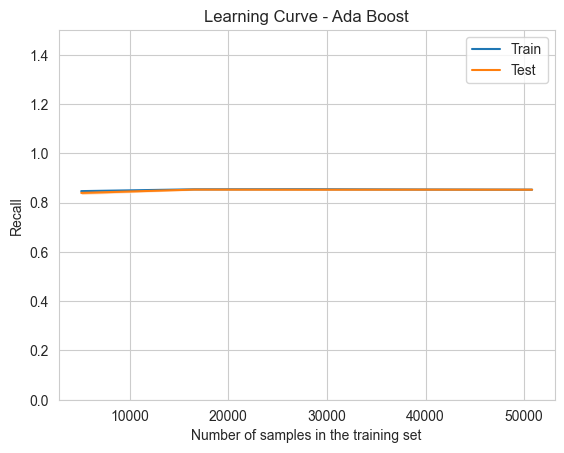

In [35]:
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(
    best_ab_classifier, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='recall'
)

display = LearningCurveDisplay(train_sizes=train_sizes_rf, train_scores=train_scores_rf, test_scores=test_scores_rf, score_name="Recall")
display.plot()
plt.title('Learning Curve - Ada Boost')
plt.ylim(0.0, 1.5)
plt.show()

# Comparison: Original vs Classifiers: Random Forest & Ada Boost

        Model  Accuracy  Recall  Precision  F1-score  ROC AUC
Decision Tree    0.8122  0.8151     0.8103    0.8127   0.8122
     AdaBoost    0.8553  0.8536     0.8565    0.8551   0.9380
 RandomForest    0.8626  0.8125     0.9028    0.8553   0.9363


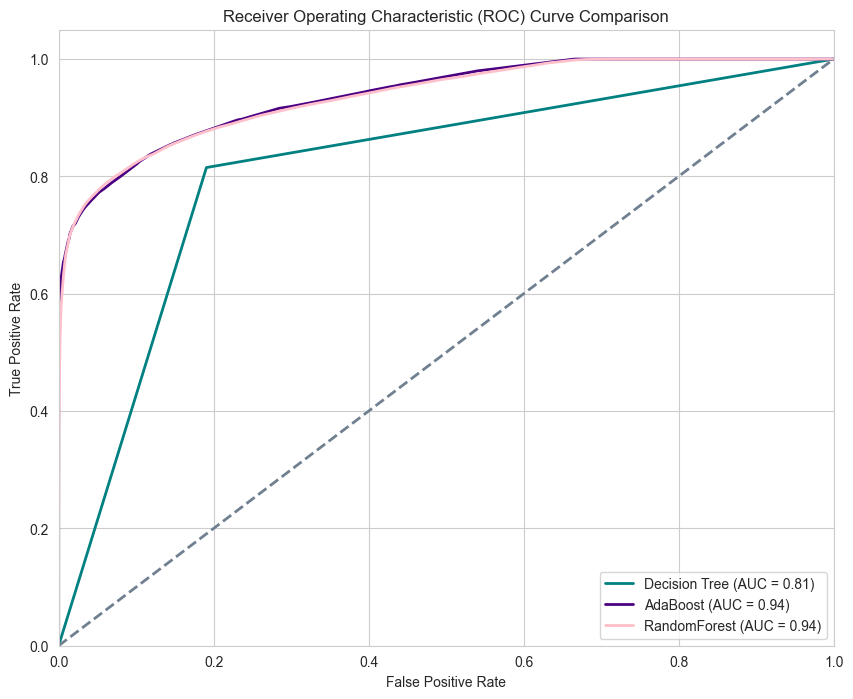

In [36]:
comparison_data = {
    'Model': ['Decision Tree', 'AdaBoost', 'RandomForest'],
    'Accuracy': [dt_metrics['Accuracy'], adaboost_metrics['Accuracy'], rf_metrics['Accuracy']],
    'Recall': [dt_metrics['Recall'], adaboost_metrics['Recall'], rf_metrics['Recall']],
    'Precision': [dt_metrics['Precision'], adaboost_metrics['Precision'], rf_metrics['Precision']],
    'F1-score': [dt_metrics['F1-score'], adaboost_metrics['F1-score'], rf_metrics['F1-score']],
    'ROC AUC': [dt_metrics['ROC AUC'], adaboost_metrics['ROC AUC'], rf_metrics['ROC AUC']]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4).to_string(index=False))

plt.figure(figsize=(10, 8))
plt.plot(dt_metrics['FPR'], dt_metrics['TPR'], color='teal', lw=2, label=f'Decision Tree (AUC = {dt_metrics["ROC AUC"]:.2f})')
plt.plot(adaboost_metrics['FPR'], adaboost_metrics['TPR'], color='indigo', lw=2, label=f'AdaBoost (AUC = {adaboost_metrics["ROC AUC"]:.2f})')
plt.plot(rf_metrics['FPR'], rf_metrics['TPR'], color='pink', lw=2, label=f'RandomForest (AUC = {rf_metrics["ROC AUC"]:.2f})')
plt.plot([0, 1], [0, 1], color='slategray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()